In [4]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from rdkit import Chem
from scipy.stats import norm
from genbench3D.geometry import AnglePattern, TorsionPattern, BondPattern
from ccdc import io
from genbench3D.params import CSD_DRUG_SUBSET_PATH
from genbench3D.utils import ccdc_mol_to_rdkit_mol, shift_torsion_values
from genbench3D.geometry import ReferenceGeometry
from genbench3D.data.source import CSDDrug
from tqdm import tqdm
from ccdc.io import Molecule
from rdkit.Chem import Mol
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from genbench3D.geometry.von_mises_kde import VonMisesKDE

In [7]:
source = CSDDrug(subset_path='/home/bb596/hdd/genbench3D/CSD_Drug_Subset.gcd')
rg = ReferenceGeometry(source,
                      root='/home/bb596/hdd/genbench3D/',
                       minimum_pattern_values=50)

In [8]:
def plot_mixture(mixture):
    n_samples_total = 100000
    all_samples = []

    means = mixture.means_.reshape(-1)
    pis = mixture.weights_.reshape(-1)
    stds = mixture.covariances_.reshape(-1)
    for pi, mean, std in zip(pis, means, stds):
        n_samples = int(pi * n_samples_total)
        # print(n_samples, np.around(mean, 2), np.around(std, 2))
        samples = norm(loc=mean, scale=np.sqrt(std)).rvs(n_samples)
        all_samples.extend(samples)
        
    sns.histplot(all_samples)
    plt.show()
    
    return all_samples

In [9]:
values = rg.read_values()

In [10]:
len(values['torsion'])

35611

In [11]:
len(rg.kernel_densities['torsion'])

5305

  0%|                                                    | 0/10 [00:00<?, ?it/s]

C(=O,-O)-C(-N,-H)-C(-H,-H)-C(-C,-H,-H)
0.9981300316507525


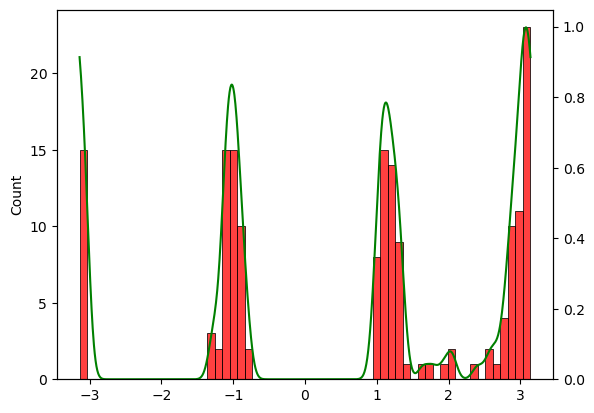

 10%|████▍                                       | 1/10 [00:00<00:03,  2.96it/s]

C(=O,-O)-C(-N,-H)-C(-C,-H)-H()
0.8172899675937434


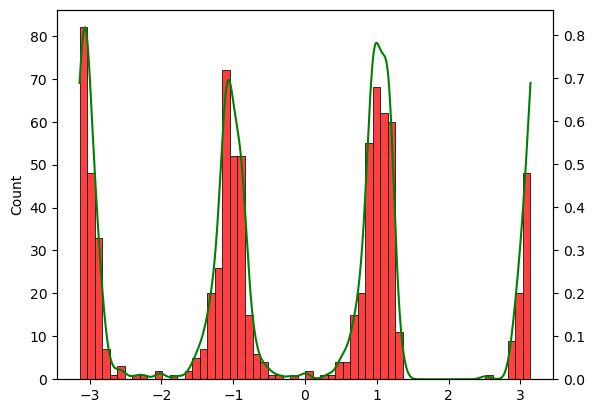

 20%|████████▊                                   | 2/10 [00:00<00:02,  2.92it/s]

H()-N[+1](-H,-H)-C(-C,-H)-C(=O,-O)
0.8550756220400316


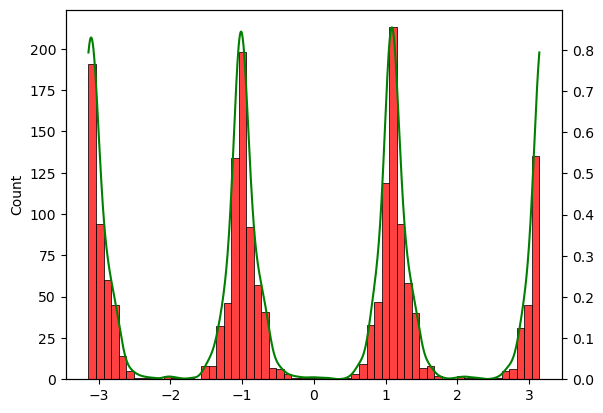

 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.91it/s]

H()-C(-C,-H)-C(-H,-H)-C(-N,-C,-H)
1.2676380855268543


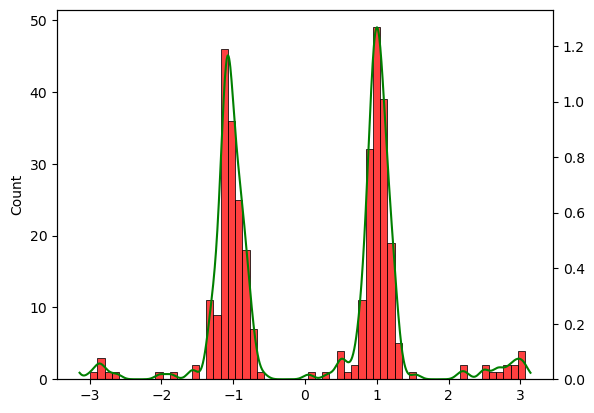

 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.94it/s]

C(-C,-H,-H)-C(-N,-H)-C(=O)-O[-1]()
0.9267663282549413


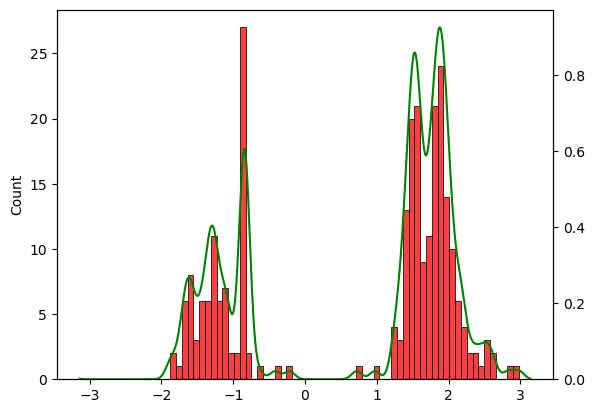

 50%|██████████████████████                      | 5/10 [00:01<00:01,  2.97it/s]

C(-C,-H,-H)-C(-N,-H)-C(-O)=O()
0.6208723576756441


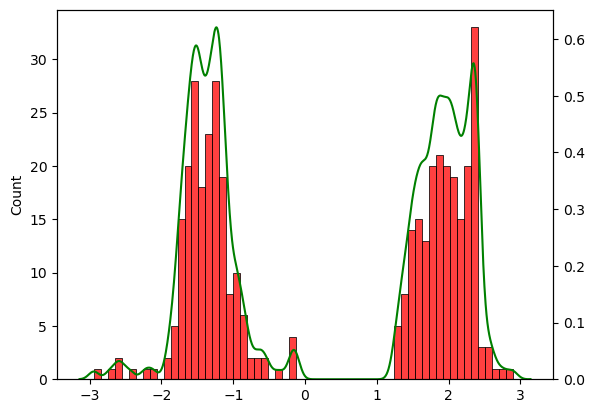

 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  2.96it/s]

H()-N[+1](-H,-H)-C(-C,-H)-C(-C,-H,-H)
0.7092632465259121


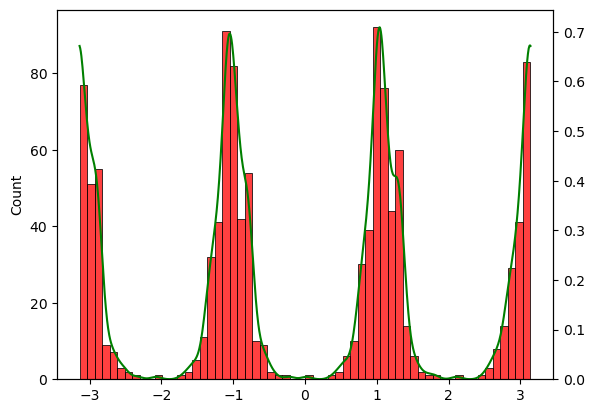

 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  2.97it/s]

N[+1](-H,-H,-H)-C(-C,-H)-C(-H,-H)-C(-C,-H,-H)
1.0713388705651583


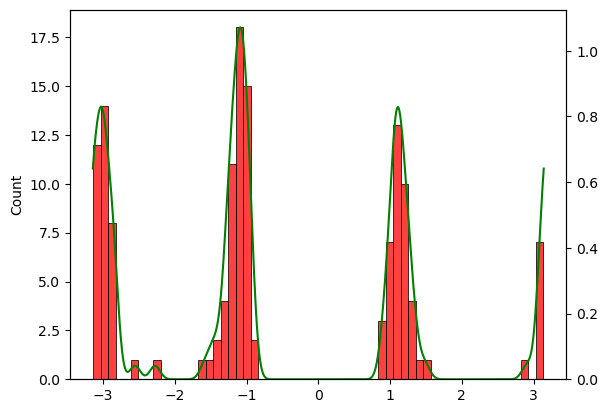

 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  2.97it/s]

H()-C(-N,-C)-C(-H,-H)-C(-C,-H,-H)
0.9381043728606707


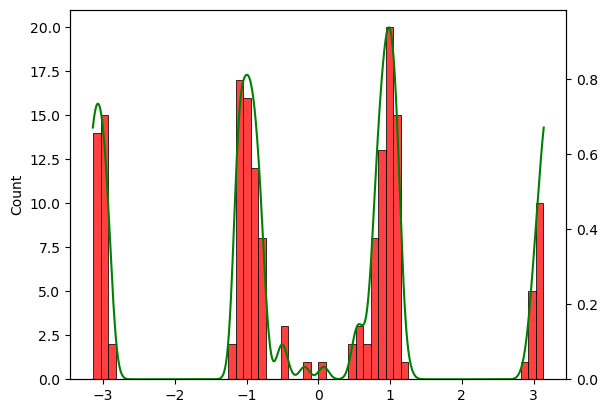

 90%|███████████████████████████████████████▌    | 9/10 [00:03<00:00,  2.97it/s]

H()-N(-H)-C(=O)-C(-C,-H,-H)
2.2332728031249443


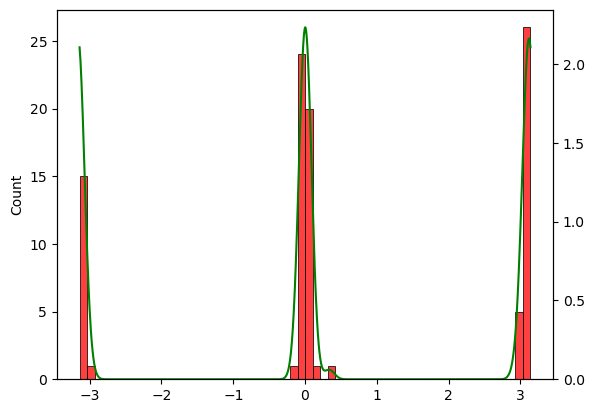

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]

3.3792059421539307


In [34]:
pattern_type = 'torsion'
items_list = list(rg.kernel_densities[pattern_type].items())
import time
start_time = time.time()
for pattern, gkd in tqdm(items_list[:10]) :
    print(pattern.to_string())
    pattern_values = values[pattern_type][pattern]
    kd = gkd.kernel_density
    print(gkd.max_likelihood)
    n_samples_total = len(pattern_values)
    all_samples = []

    # means = mixture.means_.reshape(-1)
    # pis = mixture.weights_.reshape(-1)
    # stds = mixture.covariances_.reshape(-1)
    # for pi, mean, std in zip(pis, means, stds):
    #     n_samples = int(pi * n_samples_total)
    #     # print(n_samples, np.around(mean, 2), np.around(std, 2))
    #     samples = norm(loc=mean, scale=np.sqrt(std)).rvs(n_samples)
    #     all_samples.extend(samples)

    if pattern_type == 'bond':
        padding = 0.05
        min_linspace = np.min(pattern_values) - padding
        max_linspace = np.max(pattern_values) + padding
    elif pattern_type == 'angle':
        padding = 5
        min_linspace = np.min(pattern_values) - padding
        max_linspace = np.max(pattern_values) + padding
    else:
        min_linspace = -np.pi
        max_linspace = np.pi
        pattern_values = np.radians(pattern_values)
        
    linspace = np.linspace(min_linspace, max_linspace, 10000)
    # linspace = np.append(linspace, means)
    
    # log_likelihoods = mixture.score_samples(np.array(pattern_values).mean().reshape(-1, 1))
    
    # kd = KernelDensity(bandwidth=0.01)
    # kd.fit(np.array(pattern_values).reshape(-1, 1))
    # kd = KernelDensity(bandwidth=1.0)
    # kd.fit(np.array(pattern_values).reshape(-1, 1))
    # kd = VonMisesKDE(bandwidth=200.0)
    # kd.fit(np.array(pattern_values).reshape(-1, 1))
    log_likelihoods = kd.score_samples(linspace.reshape(-1, 1))
    
    likelihoods = np.exp(log_likelihoods.reshape(-1))

    fig, ax = plt.subplots()
    sns.histplot(pattern_values, color='red', ax=ax, bins=60)
    # ax2 = ax.twinx()
    # sns.histplot(all_samples, ax=ax2)
    sns.histplot(all_samples)
    ax3 = ax.twinx()
    sns.lineplot(x=linspace, y=likelihoods, ax=ax3, color='green')
    ax3.set_ylim(0)
    plt.show()

print(time.time() - start_time)

In [35]:
np.trapz(likelihoods, x=linspace)

1.00000041583155

In [36]:
patterns = [
    ('C{6}(~C,~C)-C(=O,-C)', 'bond'),
    ('O()=C(-C)-C(-H,-H,-H)', 'angle'),
    ('C{6}(~C,-H)~C{6}(~C)-C(-C)=O()', 'torsion'),
            ]

In [37]:
pattern_class = {'bond': BondPattern,
                'angle': AnglePattern,
                'torsion': TorsionPattern}

In [38]:
sns.set_context('talk')

In [39]:
colorblind_palette = sns.color_palette("colorblind")

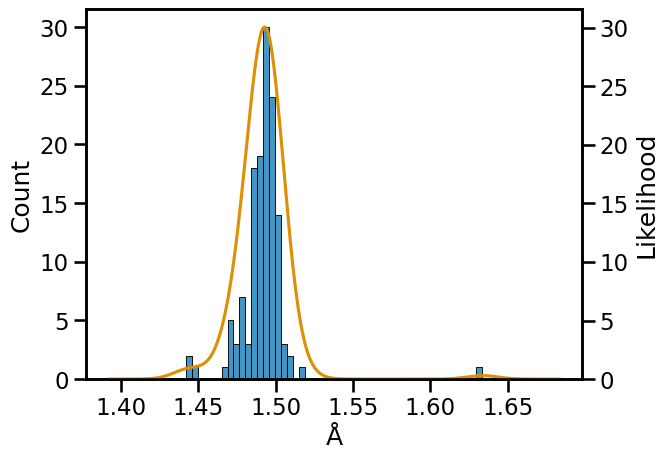

0.999999994916939


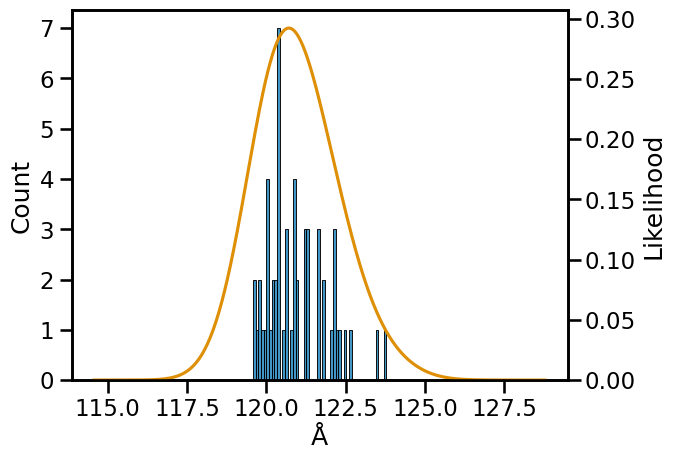

0.9999999729062138


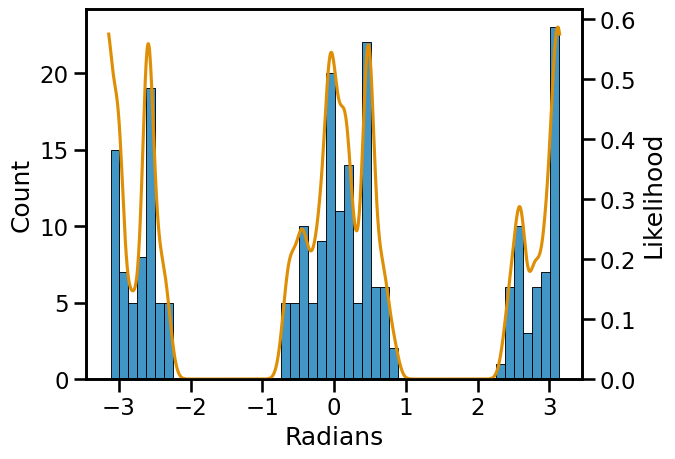

1.0000000006283185


In [40]:
for pattern_str, pattern_type in patterns:
    pattern = pattern_class[pattern_type].from_string(pattern_str)
    assert pattern in values[pattern_type]
    geometry_kd = rg.kernel_densities[pattern_type][pattern]
    geometry_values = values[pattern_type][pattern]
    if pattern_type == 'torsion':
        geometry_values = np.radians(geometry_values)
        samples = np.linspace(-np.pi, np.pi, 1000)
        unit_name = 'Radians'
    else:
        unit_name = 'Å'
        vmin = np.min(geometry_values)
        vmax = np.max(geometry_values)
        if pattern_type == 'bond':
            padding = 0.05
        else:
            padding = 5
        samples = np.linspace(vmin - padding,
                             vmax + padding,
                             1000)
    log_likelihoods = geometry_kd.kernel_density.score_samples(samples.reshape(-1, 1))
    likelihoods = np.exp(log_likelihoods.squeeze())

    fig, ax = plt.subplots()
    sns.histplot(geometry_values, bins=50, ax=ax, color=colorblind_palette[0])
    ax2 = ax.twinx()
    sns.lineplot(x=samples, y=likelihoods, ax=ax2, 
                 color=colorblind_palette[1]
                )
    ax2.set_ylim(0)
    ax2.set_ylabel('Likelihood')
    ax.set_xlabel(unit_name)
    plt.savefig(f'figures/{pattern_type}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(np.trapz(likelihoods, x=samples))